In [1]:
# import libraries
import pandas as pd # sirve para hacer operaciones de dataframes
import geopandas as gpd # sirve para hacer operaciones geoespaciales

import folium # sirve para hacer mapas interactivos
from folium import plugins # sirve para hacer mapas interactivos
from folium.plugins import HeatMap # sirve para hacer mapas interactivos 

import matplotlib.pyplot as plt # superior en cuestion de rendimiento
import matplotlib.colors as colors
import contextily as ctx # sirve para poner mapas de fondo
from pyproj import Transformer # sirve para transformar coordenadas

import seaborn as sns # para hacer graficos mas bonitos

import json # sirve para leer archivos json
import pydeck as pdk # for 3D maps, buen resultado, muy visual

from shapely.geometry import LineString, Point, box # sirve para hacer geometrias
from sklearn.preprocessing import KBinsDiscretizer # sirve para hacer bins

from scipy.stats import gaussian_kde # sirve para hacer densidades
import shapely.geometry # sirve para hacer geometrias
from pyproj import Proj, transform # sirve para transformar coordenadas

import numpy as np # sirve para hacer operaciones matematicas

In [269]:
# Variables globales
nrows = 100000
# Coordenadas de la ciudad de Oporto
minx, miny, maxx, maxy = -8.689, 41.107, -8.560, 41.185
# Ruta del archivo CSV
filename = "../train_data/taxis_trajectory/train.csv"

In [270]:
def load_and_simplify_data(filename, rows, tolerance=0.001):
    # Cargar datos
    df = pd.read_csv(filename, nrows=rows, sep=",", low_memory=False)
    
    # Filtrar polilíneas vacías o con un solo punto
    def create_line(x):
        points = json.loads(x)
        if len(points) > 1:
            return LineString(points)
        return None

    df['geometry'] = df['POLYLINE'].apply(create_line)
    
    # Eliminar filas con geometrías nulas
    df = df[df['geometry'].notnull()]
    
    # Convertir a Geopandas DataFrame
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    
    # Simplificar las geometrías
    gdf['geometry'] = gdf['geometry'].simplify(tolerance)
    
    return gdf


In [271]:
# Cargar y simplificar datos (4:16 min 1.7M de filas)
gdf = load_and_simplify_data(filename, nrows)

In [272]:
""" # Definir la resolución del raster (más alta = más detalle pero mayor costo computacional)
resolution = 100

# Obtener los límites de todas las polilíneas
bounds = gdf.total_bounds
x_min, y_min, x_max, y_max = bounds

# Crear una grilla sobre el área de interés
x_bins = np.linspace(x_min, x_max, resolution)
y_bins = np.linspace(y_min, y_max, resolution)

# Inicializar una matriz para el mapa de calor
heatmap_matrix = np.zeros((resolution - 1, resolution - 1))

# Función para rasterizar una polilínea
def rasterize_line(line, x_bins, y_bins, heatmap_matrix):
    x, y = line.xy
    x_indices = np.digitize(x, x_bins) - 1
    y_indices = np.digitize(y, y_bins) - 1
    x_indices = np.clip(x_indices, 0, heatmap_matrix.shape[1] - 1)
    y_indices = np.clip(y_indices, 0, heatmap_matrix.shape[0] - 1)
    heatmap_matrix[y_indices, x_indices] += 1

# Rasterizar cada polilínea
for line in gdf.geometry:
    rasterize_line(line, x_bins, y_bins, heatmap_matrix)

print(heatmap_matrix.min(), heatmap_matrix.max())

# Ajustar la escala de colores para mejorar la visualización
plt.figure(figsize=(10, 6))
plt.imshow(heatmap_matrix, cmap='hot', interpolation='nearest', origin='lower',
           extent=[x_min, x_max, y_min, y_max], aspect='auto', norm=plt.Normalize(vmin=0, vmax=np.quantile(heatmap_matrix, 0.99)))
plt.colorbar(label='Densidad de Rutas')
plt.title('Mapa de Calor de Superposición de Rutas')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()
 """

" # Definir la resolución del raster (más alta = más detalle pero mayor costo computacional)\nresolution = 100\n\n# Obtener los límites de todas las polilíneas\nbounds = gdf.total_bounds\nx_min, y_min, x_max, y_max = bounds\n\n# Crear una grilla sobre el área de interés\nx_bins = np.linspace(x_min, x_max, resolution)\ny_bins = np.linspace(y_min, y_max, resolution)\n\n# Inicializar una matriz para el mapa de calor\nheatmap_matrix = np.zeros((resolution - 1, resolution - 1))\n\n# Función para rasterizar una polilínea\ndef rasterize_line(line, x_bins, y_bins, heatmap_matrix):\n    x, y = line.xy\n    x_indices = np.digitize(x, x_bins) - 1\n    y_indices = np.digitize(y, y_bins) - 1\n    x_indices = np.clip(x_indices, 0, heatmap_matrix.shape[1] - 1)\n    y_indices = np.clip(y_indices, 0, heatmap_matrix.shape[0] - 1)\n    heatmap_matrix[y_indices, x_indices] += 1\n\n# Rasterizar cada polilínea\nfor line in gdf.geometry:\n    rasterize_line(line, x_bins, y_bins, heatmap_matrix)\n\nprint(heat

In [273]:
""" # Filtrar por las coordenadas especificadas
minx, miny, maxx, maxy = -8.689, 41.107, -8.560, 41.185
gdf_edit = gdf.cx[minx:maxx, miny:maxy]

# Definir la resolución del raster
resolution = 100

# Usar los límites especificados para la grilla
x_bins = np.linspace(minx, maxx, resolution)
y_bins = np.linspace(miny, maxy, resolution)

# Inicializar matriz para el mapa de calor
heatmap_matrix = np.zeros((resolution - 1, resolution - 1))

# Función para rasterizar una polilínea
def rasterize_line(line, x_bins, y_bins, heatmap_matrix):
    x, y = line.xy
    x_indices = np.digitize(x, x_bins) - 1
    y_indices = np.digitize(y, y_bins) - 1
    x_indices = np.clip(x_indices, 0, heatmap_matrix.shape[1] - 1)
    y_indices = np.clip(y_indices, 0, heatmap_matrix.shape[0] - 1)
    heatmap_matrix[y_indices, x_indices] += 1

# Rasterizar cada polilínea
for line in gdf_edit.geometry:
    rasterize_line(line, x_bins, y_bins, heatmap_matrix)

# Ajustar la escala de colores
plt.figure(figsize=(10, 6))
plt.imshow(heatmap_matrix, cmap='hot', interpolation='nearest', origin='lower',
           extent=[minx, maxx, miny, maxy], aspect='auto', norm=plt.Normalize(vmin=0, vmax=np.quantile(heatmap_matrix, 0.99)))

# Añadir el mapa base
ax = plt.gca()
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.colorbar(label='Densidad de Rutas')
plt.title('Mapa de Calor de Superposición de Rutas')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show() """

" # Filtrar por las coordenadas especificadas\nminx, miny, maxx, maxy = -8.689, 41.107, -8.560, 41.185\ngdf_edit = gdf.cx[minx:maxx, miny:maxy]\n\n# Definir la resolución del raster\nresolution = 100\n\n# Usar los límites especificados para la grilla\nx_bins = np.linspace(minx, maxx, resolution)\ny_bins = np.linspace(miny, maxy, resolution)\n\n# Inicializar matriz para el mapa de calor\nheatmap_matrix = np.zeros((resolution - 1, resolution - 1))\n\n# Función para rasterizar una polilínea\ndef rasterize_line(line, x_bins, y_bins, heatmap_matrix):\n    x, y = line.xy\n    x_indices = np.digitize(x, x_bins) - 1\n    y_indices = np.digitize(y, y_bins) - 1\n    x_indices = np.clip(x_indices, 0, heatmap_matrix.shape[1] - 1)\n    y_indices = np.clip(y_indices, 0, heatmap_matrix.shape[0] - 1)\n    heatmap_matrix[y_indices, x_indices] += 1\n\n# Rasterizar cada polilínea\nfor line in gdf_edit.geometry:\n    rasterize_line(line, x_bins, y_bins, heatmap_matrix)\n\n# Ajustar la escala de colores\np

In [274]:
""" def filter_data_in_area(gdf, minx, miny, maxx, maxy):
    # Crear un polígono de área de interés
    area_of_interest = box(minx, miny, maxx, maxy)
    
    # Filtrar los datos para incluir solo aquellos completamente dentro del área de interés
    gdf_filtered = gdf[gdf.geometry.within(area_of_interest)]
    
    return gdf_filtered """

' def filter_data_in_area(gdf, minx, miny, maxx, maxy):\n    # Crear un polígono de área de interés\n    area_of_interest = box(minx, miny, maxx, maxy)\n    \n    # Filtrar los datos para incluir solo aquellos completamente dentro del área de interés\n    gdf_filtered = gdf[gdf.geometry.within(area_of_interest)]\n    \n    return gdf_filtered '

In [275]:
""" # Filtrar por las coordenadas especificadas
minx, miny, maxx, maxy = -8.689, 41.107, -8.560, 41.185
gdf_edit = gdf.cx[minx:maxx, miny:maxy]

# Asegurarse de que el CRS es correcto para el mapa base
gdf_edit = gdf_edit.set_crs("EPSG:4326")  # Asumiendo que los datos están en WGS84
gdf_edit = gdf_edit.to_crs(epsg=3857)  # Transformar a Web Mercator

# Definir la resolución del raster
resolution = 100

# Usar los límites especificados para la grilla, transformando las coordenadas al CRS correcto
bounds = gdf_edit.total_bounds
x_min, y_min, x_max, y_max = bounds
x_bins = np.linspace(x_min, x_max, resolution)
y_bins = np.linspace(y_min, y_max, resolution)

# Inicializar matriz para el mapa de calor
heatmap_matrix = np.zeros((resolution - 1, resolution - 1))

# Función para rasterizar una polilínea
def rasterize_line(line, x_bins, y_bins, heatmap_matrix):
    x, y = line.xy
    x_indices = np.digitize(x, x_bins) - 1
    y_indices = np.digitize(y, y_bins) - 1
    x_indices = np.clip(x_indices, 0, heatmap_matrix.shape[1] - 1)
    y_indices = np.clip(y_indices, 0, heatmap_matrix.shape[0] - 1)
    heatmap_matrix[y_indices, x_indices] += 1

# Rasterizar cada polilínea
for line in gdf_edit.geometry:
    rasterize_line(line, x_bins, y_bins, heatmap_matrix)

# Visualización
fig, ax = plt.subplots(figsize=(10, 6))
# Asegúrate de que la matriz del mapa de calor esté correctamente calculada aquí
plt.imshow(heatmap_matrix, cmap='hot', interpolation='nearest', origin='lower',
           extent=[minx, maxx, miny, maxy], aspect='auto')

# Añadir el mapa base
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:3857')

# Ajustar los límites del eje al área de interés
ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])

plt.colorbar(label='Densidad de Rutas')
plt.title('Mapa de Calor de Superposición de Rutas')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show() """

' # Filtrar por las coordenadas especificadas\nminx, miny, maxx, maxy = -8.689, 41.107, -8.560, 41.185\ngdf_edit = gdf.cx[minx:maxx, miny:maxy]\n\n# Asegurarse de que el CRS es correcto para el mapa base\ngdf_edit = gdf_edit.set_crs("EPSG:4326")  # Asumiendo que los datos están en WGS84\ngdf_edit = gdf_edit.to_crs(epsg=3857)  # Transformar a Web Mercator\n\n# Definir la resolución del raster\nresolution = 100\n\n# Usar los límites especificados para la grilla, transformando las coordenadas al CRS correcto\nbounds = gdf_edit.total_bounds\nx_min, y_min, x_max, y_max = bounds\nx_bins = np.linspace(x_min, x_max, resolution)\ny_bins = np.linspace(y_min, y_max, resolution)\n\n# Inicializar matriz para el mapa de calor\nheatmap_matrix = np.zeros((resolution - 1, resolution - 1))\n\n# Función para rasterizar una polilínea\ndef rasterize_line(line, x_bins, y_bins, heatmap_matrix):\n    x, y = line.xy\n    x_indices = np.digitize(x, x_bins) - 1\n    y_indices = np.digitize(y, y_bins) - 1\n    x_

In [276]:
""" # Filtrar datos por coordenadas especificadas y establecer CRS
minx, miny, maxx, maxy = -8.689, 41.107, -8.560, 41.185
gdf_edit = gdf.cx[minx:maxx, miny:maxy]
gdf_edit = gdf_edit.set_crs("EPSG:4326")  # Asumiendo que los datos están en WGS84
gdf_edit = gdf_edit.to_crs(epsg=3857)  # Transformar a Web Mercator para visualización

# Preparar datos para el mapa de calor
resolution = 100
x_min, y_min, x_max, y_max = gdf_edit.total_bounds
x_bins = np.linspace(x_min, x_max, resolution)
y_bins = np.linspace(y_min, y_max, resolution)
heatmap_matrix = np.zeros((resolution - 1, resolution - 1))

# Función para rasterizar una polilínea
def rasterize_line(line, x_bins, y_bins, heatmap_matrix):
    x, y = line.xy
    x_indices = np.digitize(x, x_bins) - 1
    y_indices = np.digitize(y, y_bins) - 1
    for xi, yi in zip(x_indices, y_indices):
        if 0 <= xi < resolution - 1 and 0 <= yi < resolution - 1:
            heatmap_matrix[yi, xi] += 1

# Rasterizar las polilíneas
for line in gdf_edit.geometry:
    rasterize_line(line, x_bins, y_bins, heatmap_matrix)

# Visualización con mapa base
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(heatmap_matrix, cmap='hot', interpolation='nearest', origin='lower',
          extent=[x_min, x_max, y_min, y_max], aspect='auto')

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plt.colorbar(label='Densidad de Rutas')
plt.title('Mapa de Calor de Superposición de Rutas')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show() """

' # Filtrar datos por coordenadas especificadas y establecer CRS\nminx, miny, maxx, maxy = -8.689, 41.107, -8.560, 41.185\ngdf_edit = gdf.cx[minx:maxx, miny:maxy]\ngdf_edit = gdf_edit.set_crs("EPSG:4326")  # Asumiendo que los datos están en WGS84\ngdf_edit = gdf_edit.to_crs(epsg=3857)  # Transformar a Web Mercator para visualización\n\n# Preparar datos para el mapa de calor\nresolution = 100\nx_min, y_min, x_max, y_max = gdf_edit.total_bounds\nx_bins = np.linspace(x_min, x_max, resolution)\ny_bins = np.linspace(y_min, y_max, resolution)\nheatmap_matrix = np.zeros((resolution - 1, resolution - 1))\n\n# Función para rasterizar una polilínea\ndef rasterize_line(line, x_bins, y_bins, heatmap_matrix):\n    x, y = line.xy\n    x_indices = np.digitize(x, x_bins) - 1\n    y_indices = np.digitize(y, y_bins) - 1\n    for xi, yi in zip(x_indices, y_indices):\n        if 0 <= xi < resolution - 1 and 0 <= yi < resolution - 1:\n            heatmap_matrix[yi, xi] += 1\n\n# Rasterizar las polilíneas\n

In [277]:
""" resolution = 100 """

' resolution = 100 '

In [278]:
""" def filter_data_in_area(gdf, minx, miny, maxx, maxy):
    # Crear un polígono de área de interés
    area_of_interest = box(minx, miny, maxx, maxy)
    
    # Filtrar los datos para incluir solo aquellos completamente dentro del área de interés
    gdf_filtered = gdf[gdf.geometry.within(area_of_interest)]
    
    return gdf_filtered """

' def filter_data_in_area(gdf, minx, miny, maxx, maxy):\n    # Crear un polígono de área de interés\n    area_of_interest = box(minx, miny, maxx, maxy)\n    \n    # Filtrar los datos para incluir solo aquellos completamente dentro del área de interés\n    gdf_filtered = gdf[gdf.geometry.within(area_of_interest)]\n    \n    return gdf_filtered '

In [279]:
""" # Función para rasterizar una polilínea
def rasterize_line(line, x_bins, y_bins, heatmap_matrix):
    x, y = line.xy
    x_indices = np.digitize(x, x_bins) - 1
    y_indices = np.digitize(y, y_bins) - 1
    for xi, yi in zip(x_indices, y_indices):
        if 0 <= xi < resolution - 1 and 0 <= yi < resolution - 1:
            heatmap_matrix[yi, xi] += 1 """

' # Función para rasterizar una polilínea\ndef rasterize_line(line, x_bins, y_bins, heatmap_matrix):\n    x, y = line.xy\n    x_indices = np.digitize(x, x_bins) - 1\n    y_indices = np.digitize(y, y_bins) - 1\n    for xi, yi in zip(x_indices, y_indices):\n        if 0 <= xi < resolution - 1 and 0 <= yi < resolution - 1:\n            heatmap_matrix[yi, xi] += 1 '

In [280]:
""" gdf = gdf.set_crs("EPSG:4326")

# Luego, usar estas coordenadas en la función de filtrado
gdf_filtered = filter_data_in_area(gdf, minx, miny, maxx, maxy)

# Transforcion en EPSG:3857 para alinear con el mapa base de Contextily
gdf_calibrate = gdf_filtered.to_crs(epsg=3857) """

' gdf = gdf.set_crs("EPSG:4326")\n\n# Luego, usar estas coordenadas en la función de filtrado\ngdf_filtered = filter_data_in_area(gdf, minx, miny, maxx, maxy)\n\n# Transforcion en EPSG:3857 para alinear con el mapa base de Contextily\ngdf_calibrate = gdf_filtered.to_crs(epsg=3857) '

In [281]:
""" # Preparar datos para el mapa de calor
x_min, y_min, x_max, y_max = gdf_calibrate.total_bounds
x_bins = np.linspace(x_min, x_max, resolution)
y_bins = np.linspace(y_min, y_max, resolution)
heatmap_matrix = np.zeros((resolution - 1, resolution - 1))

# Rasterizar las polilíneas
for line in gdf_calibrate.geometry:
    rasterize_line(line, x_bins, y_bins, heatmap_matrix)
    
# Asumiendo que `heatmap_matrix` es tu matriz de datos
data = heatmap_matrix.flatten()  # Aplanar los datos si es necesario
data = data[data > 0]  # Filtrar los valores no significativos, ajustar según sea necesario

plt.figure(figsize=(10, 6))
plt.hist(data, bins=50, log=True)  # Usar escala logarítmica en el eje y si es necesario
plt.title('Distribución de los Datos')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.show() """

" # Preparar datos para el mapa de calor\nx_min, y_min, x_max, y_max = gdf_calibrate.total_bounds\nx_bins = np.linspace(x_min, x_max, resolution)\ny_bins = np.linspace(y_min, y_max, resolution)\nheatmap_matrix = np.zeros((resolution - 1, resolution - 1))\n\n# Rasterizar las polilíneas\nfor line in gdf_calibrate.geometry:\n    rasterize_line(line, x_bins, y_bins, heatmap_matrix)\n    \n# Asumiendo que `heatmap_matrix` es tu matriz de datos\ndata = heatmap_matrix.flatten()  # Aplanar los datos si es necesario\ndata = data[data > 0]  # Filtrar los valores no significativos, ajustar según sea necesario\n\nplt.figure(figsize=(10, 6))\nplt.hist(data, bins=50, log=True)  # Usar escala logarítmica en el eje y si es necesario\nplt.title('Distribución de los Datos')\nplt.xlabel('Valor')\nplt.ylabel('Frecuencia')\nplt.show() "

In [282]:
""" # Crear una normalización logarítmica
norm = colors.LogNorm(vmin=heatmap_matrix.min()+1, vmax=heatmap_matrix.max())

# Crear una figura con Matplotlib
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
mappable = ax.imshow(heatmap_matrix, cmap='plasma', norm=norm ,extent=[x_min, x_max, y_min, y_max], aspect='auto', alpha=0.7, zorder=2)

# Añadir un mapa base con Contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)


plt.colorbar(mappable, label='Densidad de Rutas')
plt.title('Mapa de Calor de Superposición de Rutas')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show() """

" # Crear una normalización logarítmica\nnorm = colors.LogNorm(vmin=heatmap_matrix.min()+1, vmax=heatmap_matrix.max())\n\n# Crear una figura con Matplotlib\nfig, ax = plt.subplots(figsize=(10, 10), dpi=300)\nmappable = ax.imshow(heatmap_matrix, cmap='plasma', norm=norm ,extent=[x_min, x_max, y_min, y_max], aspect='auto', alpha=0.7, zorder=2)\n\n# Añadir un mapa base con Contextily\nctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)\n\n\nplt.colorbar(mappable, label='Densidad de Rutas')\nplt.title('Mapa de Calor de Superposición de Rutas')\nplt.xlabel('Longitud')\nplt.ylabel('Latitud')\nplt.show() "

In [283]:
""" def filter_data_in_area(gdf, minx, miny, maxx, maxy):
    # Crear un polígono de área de interés
    area_of_interest = box(minx, miny, maxx, maxy)
    
    # Filtrar los datos para incluir solo aquellos completamente dentro del área de interés
    gdf_filtered = gdf[gdf.geometry.within(area_of_interest)]
    
    return gdf_filtered

# Función para rasterizar una polilínea
def rasterize_line(line, x_bins, y_bins, heatmap_matrix):
    x, y = line.xy
    x_indices = np.digitize(x, x_bins) - 1
    y_indices = np.digitize(y, y_bins) - 1
    for xi, yi in zip(x_indices, y_indices):
        if 0 <= xi < resolution - 1 and 0 <= yi < resolution - 1:
            heatmap_matrix[yi, xi] += 1

gdf = gdf.set_crs("EPSG:4326")

# Luego, usar estas coordenadas en la función de filtrado
gdf_filtered = filter_data_in_area(gdf, minx, miny, maxx, maxy)

# Transforcion en EPSG:3857 para alinear con el mapa base de Contextily
gdf_calibrate = gdf_filtered.to_crs(epsg=3857)

# Preparar datos para el mapa de calor
x_min, y_min, x_max, y_max = gdf_calibrate.total_bounds
x_bins = np.linspace(x_min, x_max, resolution)
y_bins = np.linspace(y_min, y_max, resolution)
heatmap_matrix = np.zeros((resolution - 1, resolution - 1))

# Rasterizar las polilíneas
for line in gdf_calibrate.geometry:
    rasterize_line(line, x_bins, y_bins, heatmap_matrix)

# Crear una figura con Matplotlib
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
#gdf_calibrate.plot(ax=ax, linewidth=0.5, color='blue')
mappable = ax.imshow(heatmap_matrix, cmap='hot', interpolation='nearest', origin='lower',
                     extent=[x_min, x_max, y_min, y_max], aspect='auto')

# Añadir un mapa base con Contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Guardar la imagen
plt.colorbar(mappable, label='Densidad de Rutas')
plt.title('Mapa de Calor de Superposición de Rutas')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show() """

' def filter_data_in_area(gdf, minx, miny, maxx, maxy):\n    # Crear un polígono de área de interés\n    area_of_interest = box(minx, miny, maxx, maxy)\n    \n    # Filtrar los datos para incluir solo aquellos completamente dentro del área de interés\n    gdf_filtered = gdf[gdf.geometry.within(area_of_interest)]\n    \n    return gdf_filtered\n\n# Función para rasterizar una polilínea\ndef rasterize_line(line, x_bins, y_bins, heatmap_matrix):\n    x, y = line.xy\n    x_indices = np.digitize(x, x_bins) - 1\n    y_indices = np.digitize(y, y_bins) - 1\n    for xi, yi in zip(x_indices, y_indices):\n        if 0 <= xi < resolution - 1 and 0 <= yi < resolution - 1:\n            heatmap_matrix[yi, xi] += 1\n\ngdf = gdf.set_crs("EPSG:4326")\n\n# Luego, usar estas coordenadas en la función de filtrado\ngdf_filtered = filter_data_in_area(gdf, minx, miny, maxx, maxy)\n\n# Transforcion en EPSG:3857 para alinear con el mapa base de Contextily\ngdf_calibrate = gdf_filtered.to_crs(epsg=3857)\n\n# Pre

In [284]:
# Crear listas vacías para las coordenadas x e y
x_coords_flat = []
y_coords_flat = []

# Iterar sobre cada geometría en el GeoDataFrame
for geom in gdf['geometry']:
    # Verificar que la geometría sea una LineString
    if isinstance(geom, shapely.geometry.LineString):
        # Iterar sobre cada punto en la LineString
        for point in geom.coords:
            x_coords_flat.append(point[0])  # Añadir la coordenada x a la lista
            y_coords_flat.append(point[1])  # Añadir la coordenada y a la lista


In [303]:
bin_count = 300
posicion_x = 0
posicion_y = 0
zoom = 2

c:\Users\Álvaro\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\Álvaro\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\Álvaro\AppData\Local\Temp\ipykernel_13612\3683642750.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/g

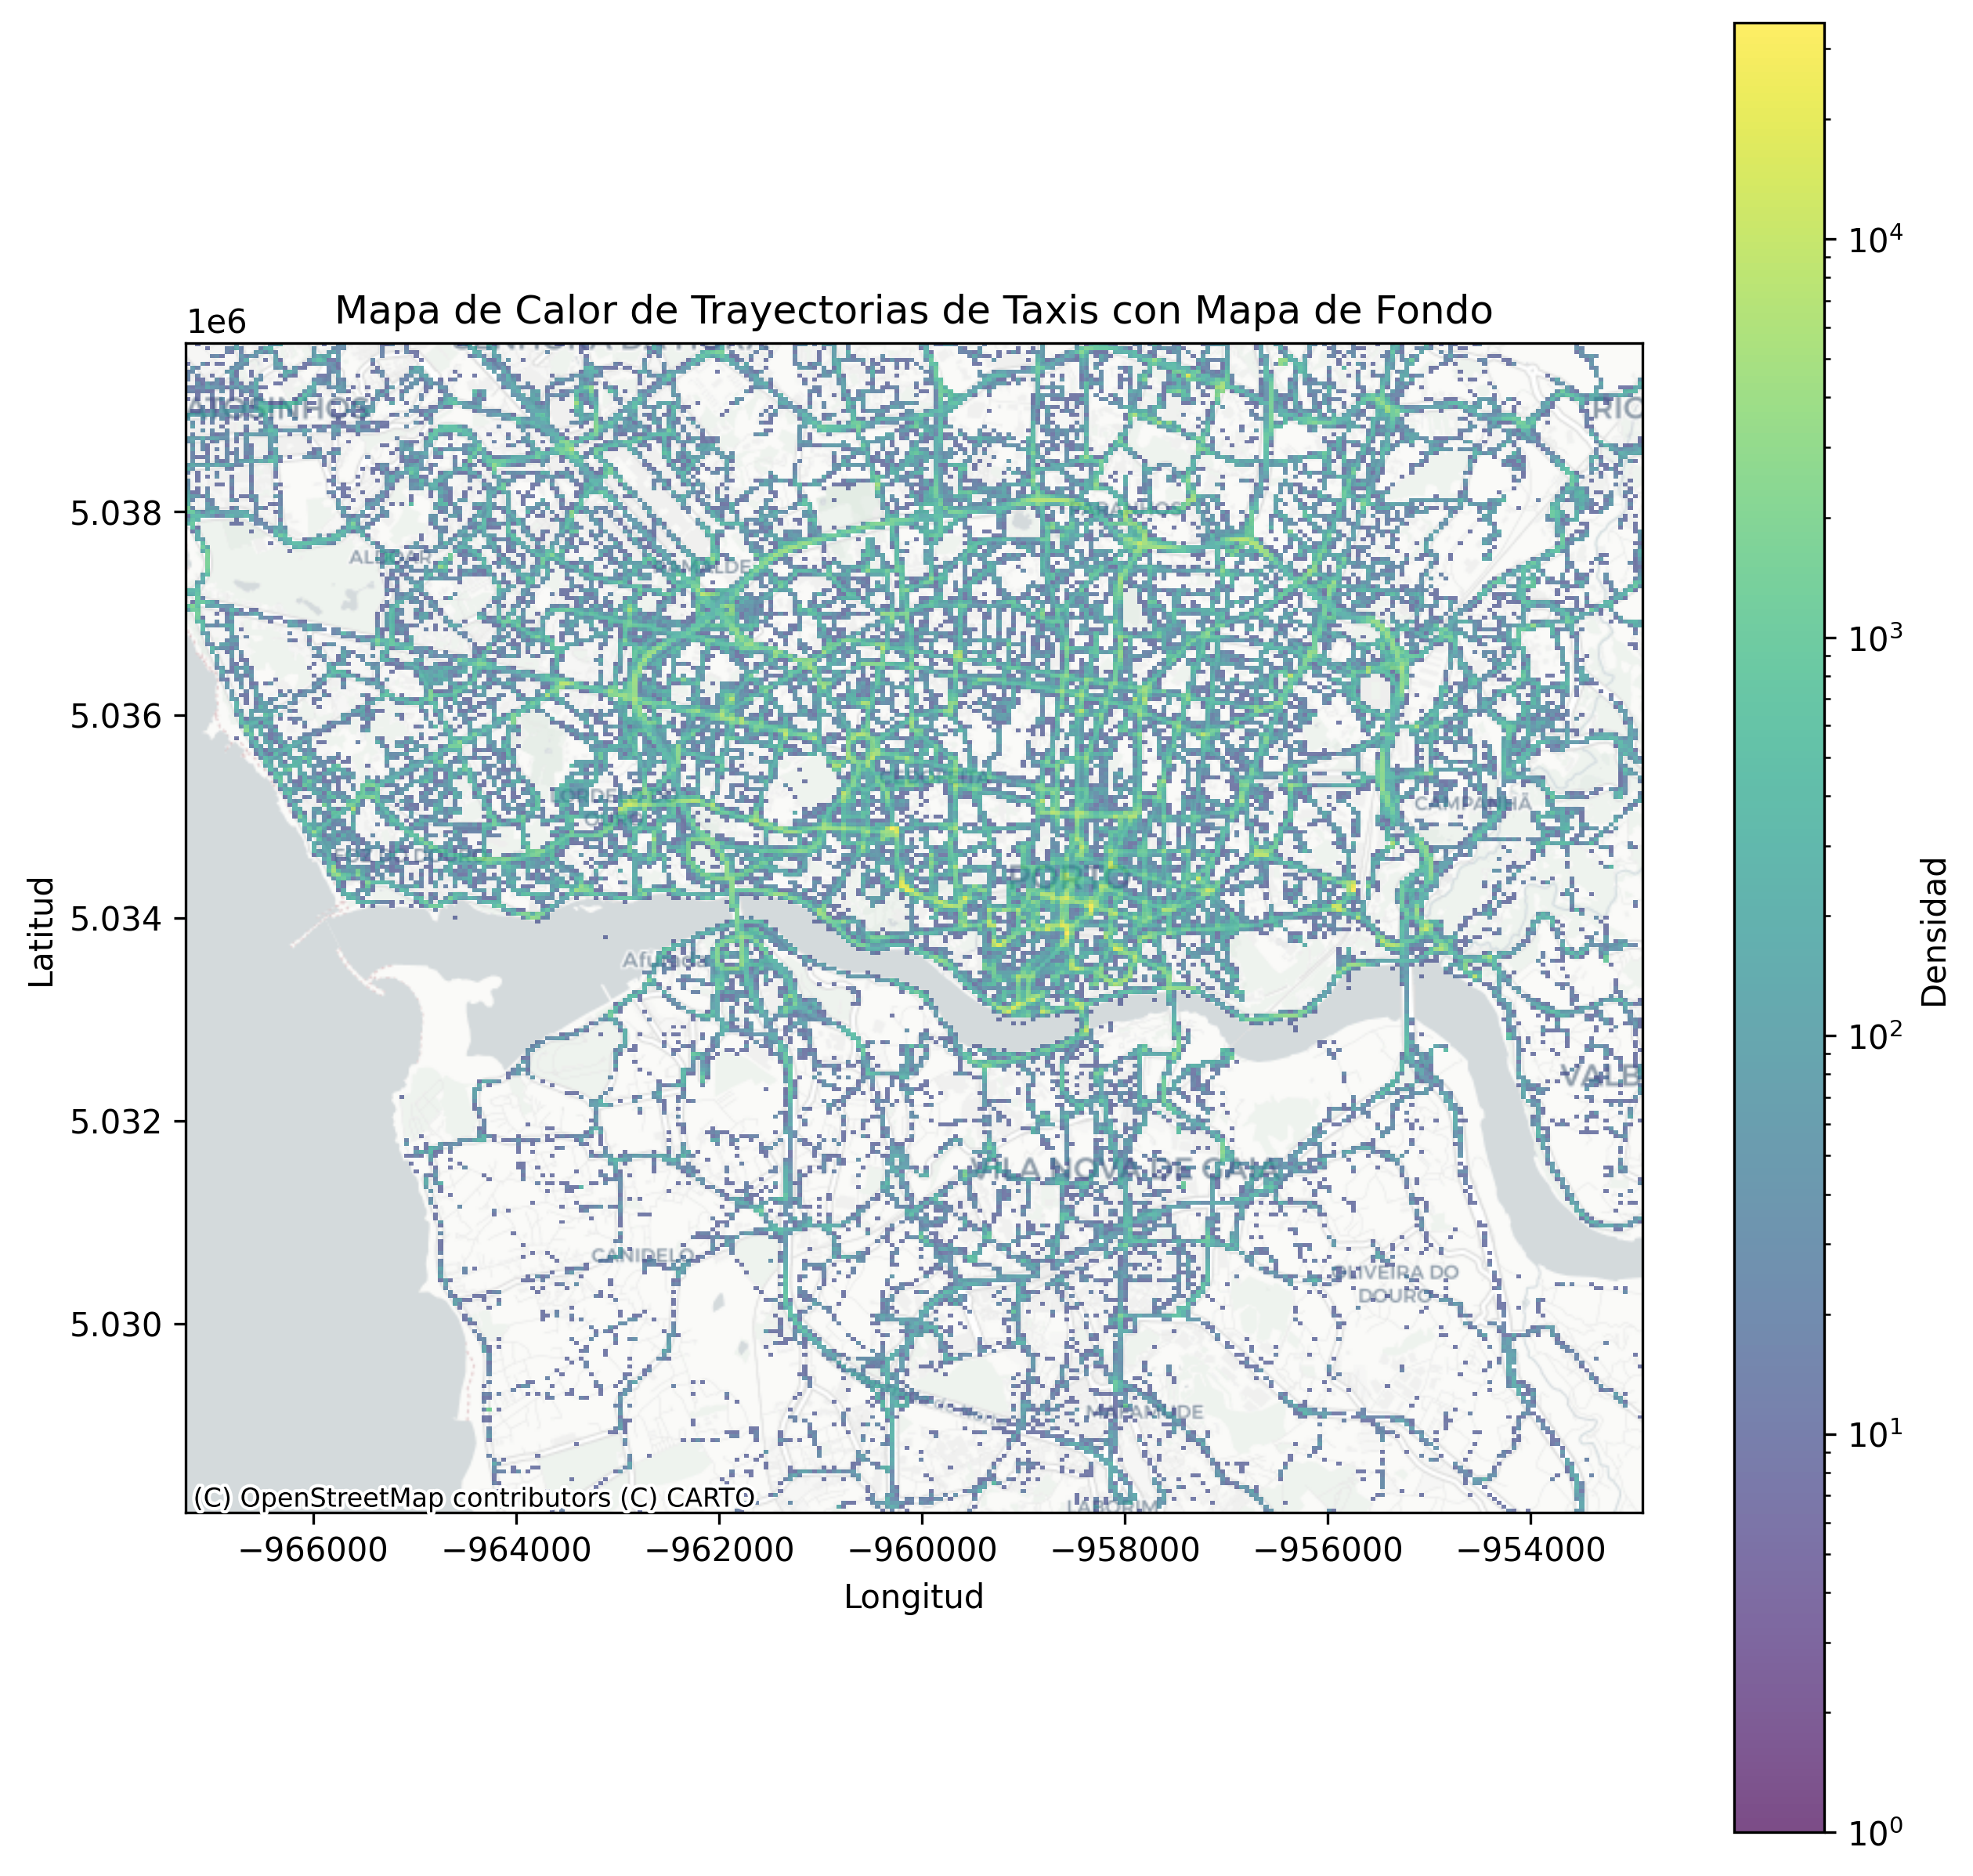

In [304]:
# Calcular el histograma bidimensional de las coordenadas x e y
heatmap, _, _ = np.histogram2d(x_coords_flat, y_coords_flat, bins=bin_count, density=True, range=[[minx, maxx], [miny, maxy]])

# Transformar coordenadas de lat/lon a Web Mercator para contextily
""" xmin, xmax = np.min(x_coords_flat), np.max(x_coords_flat)
ymin, ymax = np.min(y_coords_flat), np.max(y_coords_flat) """
xmin, ymin = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), minx, miny)
xmax, ymax = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), maxx, maxy)

x_center, y_center = ((xmin + xmax) / 2) + posicion_x, ((ymin + ymax) / 2) + posicion_y
x_range, y_range = (xmax - xmin) / zoom, (ymax - ymin) / zoom

# Crear la figura y los ejes para matplotlib
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

# Crear una normalización logarítmica
norm = colors.LogNorm(vmin=heatmap.min()+1, vmax=heatmap.max())

# Mostrar el mapa de calor y capturar el objeto mappable retornado por imshow
mappable = ax.imshow(heatmap.T, origin='lower', norm=norm ,extent=[xmin, xmax, ymin, ymax], aspect='auto', alpha=0.7, zorder=2)

# Añadir el mapa base
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom='auto')

# Ajustar los límites de los ejes para coincidir con los bordes del histograma
ax.set_xlim(x_center - x_range, x_center + x_range)
ax.set_ylim(y_center - y_range, y_center + y_range)
""" ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax) """

# Añadir barra de color, títulos y etiquetas usando el objeto mappable
plt.colorbar(mappable, label='Densidad')
plt.title('Mapa de Calor de Trayectorias de Taxis con Mapa de Fondo')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

plt.show()

In [288]:
""" # Inicializar el transformador de coordenadas
transformer = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)

# Transformar coordenadas
xmin, ymin = transformer.transform(np.min(x_coords_flat), np.min(y_coords_flat))
xmax, ymax = transformer.transform(np.max(x_coords_flat), np.max(y_coords_flat))

# Ajustar los límites para hacer zoom en una región específica si es necesario
# Por ejemplo, podemos hacer un zoom centrado en los valores medios, ajustando el rango
x_center, y_center = (xmin + xmax) / 2, (ymin + ymax) / 2
x_range, y_range = (xmax - xmin) / 4, (ymax - ymin) / 4  # Ajusta estos valores para cambiar el zoom

# Calcular el histograma bidimensional de las coordenadas x e y, normalizado
bin_count = 350
heatmap, xedges, yedges = np.histogram2d(x_coords_flat, y_coords_flat, bins=bin_count, density=True)
heatmap_normalized = heatmap / heatmap.max()

# Crear la figura y los ejes para matplotlib
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

# Mostrar el mapa de calor normalizado
mappable = ax.imshow(heatmap_normalized.T, origin='lower', extent=[xmin, xmax, ymin, ymax], aspect='auto', alpha=0.6, cmap='viridis', zorder=2)

# Añadir el mapa base
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Ajustar los límites de los ejes para hacer zoom
ax.set_xlim(x_center - x_range, x_center + x_range)
ax.set_ylim(y_center - y_range, y_center + y_range)

# Añadir barra de color, títulos y etiquetas
plt.colorbar(mappable, label='Densidad Normalizada')
plt.title('Mapa de Calor de Trayectorias de Taxis con Mapa de Fondo')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

plt.show() """

' # Inicializar el transformador de coordenadas\ntransformer = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)\n\n# Transformar coordenadas\nxmin, ymin = transformer.transform(np.min(x_coords_flat), np.min(y_coords_flat))\nxmax, ymax = transformer.transform(np.max(x_coords_flat), np.max(y_coords_flat))\n\n# Ajustar los límites para hacer zoom en una región específica si es necesario\n# Por ejemplo, podemos hacer un zoom centrado en los valores medios, ajustando el rango\nx_center, y_center = (xmin + xmax) / 2, (ymin + ymax) / 2\nx_range, y_range = (xmax - xmin) / 4, (ymax - ymin) / 4  # Ajusta estos valores para cambiar el zoom\n\n# Calcular el histograma bidimensional de las coordenadas x e y, normalizado\nbin_count = 350\nheatmap, xedges, yedges = np.histogram2d(x_coords_flat, y_coords_flat, bins=bin_count, density=True)\nheatmap_normalized = heatmap / heatmap.max()\n\n# Crear la figura y los ejes para matplotlib\nfig, ax = plt.subplots(figsize=(10, 10), dpi=300)\n\n# 